# Using a nn to interpret sign language

To start, various libraries are imported.

In [47]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import accuracy_score
import pickle
import sys
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import OneHotEncoder

First, we load the data.

In [49]:
# Load data
with open('../data/pickled/x_interp.pickle', 'rb') as f:
    x = pickle.load(f)

with open('../data/pickled/y.pickle', 'rb') as f:
    y_words = pickle.load(f)

In [68]:
# Convert words into integers using a dictionary
# If opening newer pickled files from nn-importer-interpolator.ipynb then this isn't necessary
y_dict = {word:i for i,word in zip(range(len(np.unique(y_words))),np.unique(y_words))}
y = np.array([y_dict[key] for key in y_words]).reshape(-1,1)

In [69]:
y = OneHotEncoder(sparse=False).fit_transform(y)

In [71]:
# Train/test split

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, random_state=0)

Now let's define some useful functions for the neural network to use. First is the sigmoid activation function:

In [72]:
# Sigmoid function
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [73]:
def nn(weights,x,y):
    
    ### Initialization
    n = len(x)
    activations = [np.array(0) for i in range(n_layers)]
    activations[0] = x
    deltas = [np.array(0) for i in range(n_layers-1)]
    bias = np.ones((n,1))
    
    ### Forward propagation
    for w,l in zip(weights,range(1,n_layers)):
        inputs = np.concatenate((bias,activations[l-1]),axis=1)
        activations[l] = sigmoid(np.dot(inputs,w.T))
    
    ### Output error
    deltas[-1] = activations[-1] - y
    
    ### Back propagation
    for l in range(2,n_layers):
        deltas[-l] = np.dot(deltas[-(l-1)],weights[-(l-1)][:,1:]) * activations[-l]*(1-activations[-l])
        
    # Update the weights / biases
    for w,l in zip(weights,range(len(layers)-1,0,-1)):
        w[:,1:] = w[:,1:] * (1-rate*Lambda/n) - np.dot(deltas[-l].T,activations[-(l+1)])*rate/n
        w[:,:1] -= np.sum(deltas[-l])*rate/n
        
    return weights

Next is the predict function. This function takes the learned weights and performs forward propagation through the netwwork using the x values supplied in the arguments. The effect of this is essentially to predict the output class of the given data using the weights that have been learned. We also calculate the cost here, because the actual cost value (and it's calculation) is only necessary if monitoring is set to True. Note: this function is only called by the accuracy tools at the end, and thus doesn't need to perform backpropagation or do any learning.

In [74]:
def predict(weights,x,y):
    
    ### Initialization
    n = len(x)
    activations = [np.array(0) for i in range(n_layers)]
    activations[0] = x
    bias = np.ones((n,1))
    
    ### Forward propagation
    for w,l in zip(weights,range(1,n_layers)):
        inputs = np.concatenate((bias,activations[l-1]),axis=1)
        activations[l] = sigmoid(np.dot(inputs,w.T))
    
    # Cost function: regularized cross entropy
    C = np.sum(np.nan_to_num(-y*np.log(activations[-1]) - (1-y)*(np.log(1-activations[-1]))))/n
    
    ws_sum_squares = 0
    for l in range(n_layers-1):
        ws_sum_squares += np.sum(weights[l][:,1:]**2)
        
    C += ((Lambda/(2*n))) * ws_sum_squares # Add regularization to the cost function
    
    return np.argmax(activations[-1],axis=1),C

We initialize theta with a set of random weights with a standard deviation of $ 1/\sqrt{n} $

In [75]:
def weight_init(L_in,L_out):
    np.random.seed(13) # This makes testing consistent.
    return np.random.normal(scale=1/np.sqrt(L_in), size=(L_out,L_in+1))

## Stochastic gradient descent

This function handles the SGD part of the learning, and will be called later on in the script when we're ready to learn the model.

First, the function calls *weight_init()* to initialize the starting weights. Empty lists are created for storing the costs and accuracies over the course of learning. Next, the function loops over the number of epochs. In each loop, the *x* and *y* matrices are shuffled and divided into mini-batches. Looping through all of the mini-batches, the *nn()* function is called to perform forward and backpropagation and update the weights accordingly. If the monitor flags are set when calling *SDG()* the predict function will produce the cost and accuracies and store them in the empty lists we created earlier.

In [76]:
def SGD(x,y,monitor_cost,monitor_train_acc,monitor_test_acc):
    
    # Make list of weights arrays
    weights = [np.array(0) for i in range(len(layers)-1)]
    for l in range(len(layers)-1):
        weights[l] = weight_init(layers[l],layers[l+1]) #[layers-1,[L_in+1,Lout]]
        
    def shuffle(x,y):
        state = np.random.get_state()
        np.random.shuffle(x)
        np.random.set_state(state)
        np.random.shuffle(y)
        return x,y        
        
    costs, test_acc, train_acc = [],[],[]
    for j in range(epochs):
        
        # Shuffle the data
        x,y = shuffle(x,y)

        # Seperate x,y mini-batches
        mini_x = [x[k:k+minibatchsize] for k in range(0,len(x),minibatchsize)]
        mini_y = [y[k:k+minibatchsize] for k in range(0,len(y),minibatchsize)]
        
        # Iterate through pairs of mini-batches, calling nn() on each pair
        for x_mini,y_mini in zip(mini_x,mini_y):
            weights = nn(weights,x_mini,y_mini)
        
        # If statements for monitoring. This ensures the predict() function isn't called unnecessarily
        if monitor_cost | monitor_train_acc:
            ypred, C = predict(weights,x,y)
        if monitor_cost:
            costs.append(C)
        if monitor_train_acc:
            train_acc.append(accuracy_score(np.argmax(y,axis=1),ypred))
        if monitor_test_acc:
            test_acc.append(accuracy_score(np.argmax(ytest,axis=1),predict(weights,xtest,ytest)[0]))
        
        # Write progress monitor
        progress = (j+1)/(epochs)*100.0
        bar = 20
        hashes = '#'*(int(round(progress/100*bar)))
        spaces = ' '*(bar-len(hashes))
        sys.stdout.write('\r[{0}] {1}%'.format(hashes + spaces, round(progress,2)))
                    
    return weights,costs,train_acc,test_acc

## Finally, we train the model

First, we specify the model parameters. Lambda is the regularization parameter, which protects against overfitting. The variable *classes* specifies the number of nodes in the output layer, *m* is the number of features in the data set (this also doubles as the number of input layers, see below), and *epochs*, *minibatchsize* and *rate* parameters are fairly self explanatory.

The *layers* variable is a list, wherin each element of the list corresponds to a layer in the network (including the input and output layers). For example, the three layer network we've been working with until now is defined by [784, 100, 10], i.e. 784 features in the input layer, 100 neurons in the single hidden layer, and 10 output neurons.

Now that all of the various elements have been coded, and the parameters have been set, we're ready to train the model using the training set, and plot the cost/accuracies.

In [111]:
# Model parameters
m = np.int(xtrain.shape[1]) # Number of features in each example
layers = [m, 1000, 500, 250, 96]
n_layers = len(layers)

# Learning parameters
Lambda = 0
epochs = 10
minibatchsize = 1000
rate = 10

# Train the model
weights, costs, train_acc, test_acc = SGD(xtrain,ytrain,True,True,True)

[####################] 100.0%

/home/nobody/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


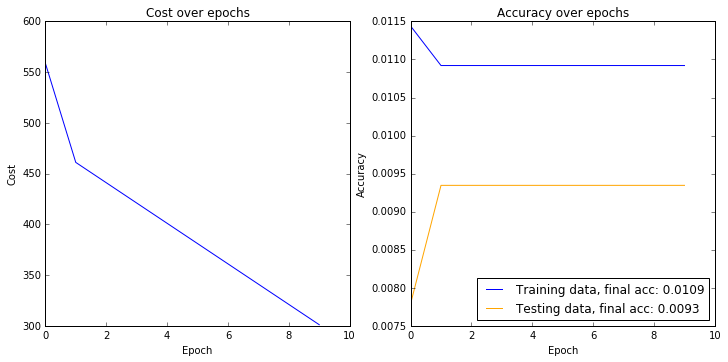

In [112]:
# Plot the results
# Note: don't bother calling unless the monitor parameters are set...
plot()

## Visualizing cost and accuracy as a function of epochs

This quick code simply plots the cost versus number of epochs and training and testing set accuracies versus number of epochs

In [97]:
def plot():# Visualize the cost and accuracy
    fig = plt.figure(figsize=(12, 12))

    ax = fig.add_subplot(221)
    ax.plot(np.arange(epochs), costs, "-")
    ax.set_xlim([0, epochs])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Cost')
    ax.set_title('Cost over epochs')

    ax = fig.add_subplot(222)
    ax.plot(np.arange(epochs), train_acc, "-",color='blue',label="Training data, final acc: "+str(round(train_acc[-1],4)))
    ax.plot(np.arange(epochs), test_acc, "-",color='orange',label="Testing data, final acc: "+str(round(test_acc[-1],4)))
    ax.set_xlim([0, epochs])
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy')
    plt.legend(loc='lower right')
    ax.set_title('Accuracy over epochs')

    plt.show()